## 1. Libraries and Constants

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing import image

In [2]:
IMAGE_SIZE = 250
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## 2. Data Loading and Sampling

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

def sample_dataset(ds, fraction=1/15):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    sampled_size = int(ds_size * fraction)
    ds = ds.take(sampled_size)
    return ds

dataset = sample_dataset(dataset)
len(dataset) # Batch quantity 

Found 75000 files belonging to 5 classes.


2024-09-13 23:48:25.816515: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-13 23:48:25.816544: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-13 23:48:25.816551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-13 23:48:25.816565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 23:48:25.816576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


156

2024-09-13 23:49:27.497112: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


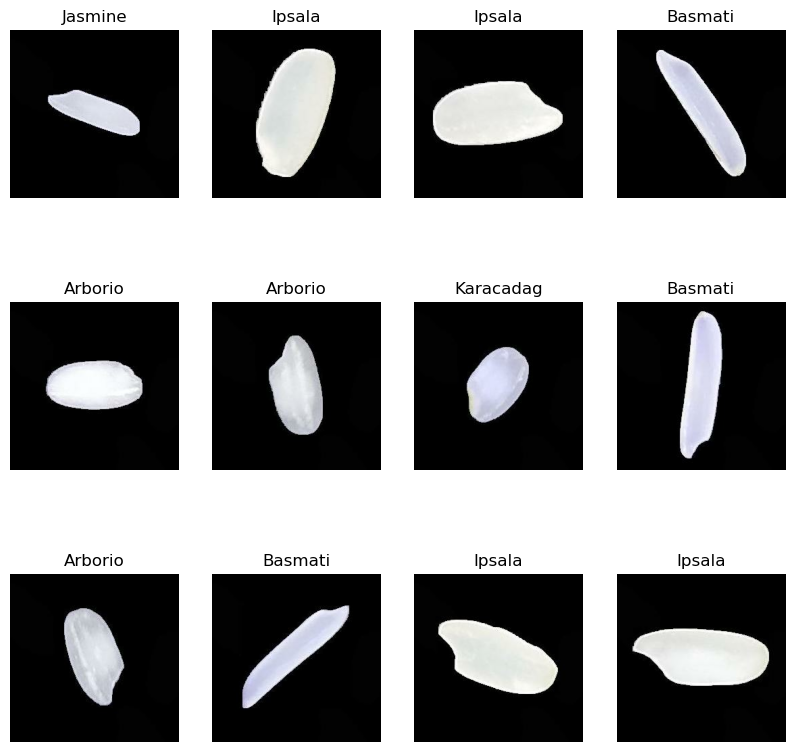

In [4]:
plt.figure(figsize=(10,10))
for image_batch, image_label in dataset.take(1):  # Take 1 batch and in shuffle mode(Everytime is diffrent)
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[image_label[i]])
        plt.axis("off")

In [ ]:
# Creating function for split dataset

## In tensorflow there is no ready-func for split so we create one

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
# Calling our func for split

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# Control

len(train_ds), len(val_ds), len(test_ds)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Resize and rescale

resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Make sure everything in the same size
    layers.Rescaling(1.0/256) # Make every channel rate between 0 and 1
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),  # Daha küçük bir model
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

# Öğrenme oranını azaltarak optimizörü yeniden tanımlayalım
optimizer = Adam(learning_rate=1e-5)  # Öğrenme oranını daha küçük bir değere çekiyoruz

model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Train the model

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint_callback]
)

In [ ]:
score = model.evaluate(test_ds)

In [ ]:
model_version = 1
save_dir = f"./models/{model_version}.keras"

# Klasörün var olup olmadığını kontrol et ve gerekirse oluştur
os.makedirs(os.path.dirname(save_dir), exist_ok=True)

# Modeli kaydet
model.save(save_dir)

In [ ]:
# Load the model
model_version = 1
model_path = f"./models/{model_version}.keras"
model = tf.keras.models.load_model(model_path)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f"Predicted: {predicted_class} ({confidence}%)\nActual: {actual_class}")
        plt.axis('off')